# Calculation and visualization of the Michel-Lévy color chart  (2/2)

This notebook summarizes the calculations of part 1 and shows some applications.

Possible applications shown here are:
- Custom Michel-Lévy charts 
    - for different ranges of thickness and birefringence.
    - with specific lines of constant birefringence (e.g. to draw ranges or mark certain minerals)
- Direct plot of interference color as function of thickness and birefringence (Mr. Sørensen calls it Raith-Sørensen chart).
- Plot interference color
    - as function of birefringence for a fixed thickness (colors in an ideal thin section)
    - as function of thickness for a fixed birefringence (situation at the edge of the thin section or at grain-boundaries)
    - for one pair of values (what color should the mineral have?)
    
More ideas:
- color for different indicatrix orientations
- simulate anomaleous colors by including absorbance of mineral

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
wavelengths = np.arange(360, 830, 1)

# Summary of all the code required for the calculations 
Here are all the necessary calculations from the previous notebook summarized into one function (plus the import and interpolation of the CIE data):

In [14]:
""" import and interpolate CIE data """
def read_csv(filename):
    with open(filename, "r") as f:
        content = f.read()
    data = []
    for line in content.splitlines():
        row = []
        for element in line.split(","):
            if element == "":
                element = 0
            row.append(float(element))
        data.append(row)
    return np.array(data)
        
#--- interpolation 
filename = "ciexyz31_1.csv"
csvdata = read_csv(filename)

xdata = csvdata.T[0,:]
XYZ = (csvdata.T[1:])

XYZ_interpol = np.ones([3,len(wavelengths)])

for i,ydata in enumerate(XYZ):
    XYZ_interpol[i, :] = np.interp(wavelengths, xdata, ydata)

In [15]:
""" all calculations in one function """
def calculate_color(Gamma, gamma_factor=0.5):
    """ Calculate and correct the interference color
    for one path difference Gamma.
    
    Parameters
    ----------
    Gamma : path difference
    gamma_factor : factor for gamma correction (optional; default=0.5)
    
    Returns
    -------
    RGB-Value normalized to 1 as numpy-array
    """
    
    #--- calculate transmission
    L = np.zeros([len(wavelengths), 1])

    for i,wl in enumerate(wavelengths):
        val = (Gamma/wl)*180
        val = np.sin(val*np.pi/180)
        val = val**2
        L[i,:] = val

    #--- convert to XYZ and sum over wavelengths
    L_XYZ = np.dot(XYZ_interpol, L)

    #--- conversion to SRGB
    XYZ_to_RGB = np.array([[3.2406, -1.5372, -0.4986],
                            [-0.9689, 1.8758, 0.0415],
                            [0.0557, -0.2040, 1.0570]])
    RGB = np.dot(XYZ_to_RGB, L_XYZ)
    
    #--- clipping
    RGB[RGB>100]=100
    RGB[RGB<0]=0

    #--- normalize
    RGB/=100
    
    #---gamma correction
    RGB = RGB**gamma_factor
    
    return RGB.ravel()

## Example: Extended Michel-Lévy Chart and custom lines to mark area of interest

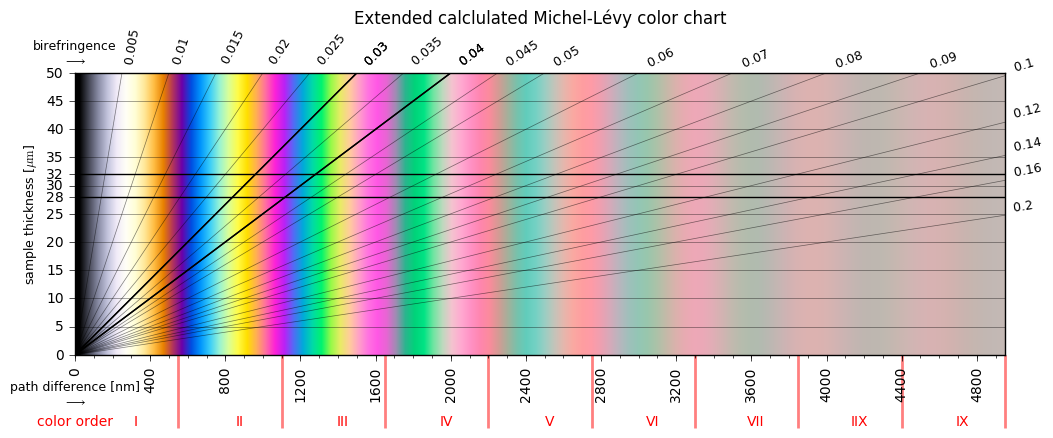

In [16]:
# --- setup 
birefringences = np.arange(0, 0.1, 0.001)
thicknesses = np.arange(0,51,1)

thickness = max(thicknesses)*1000
RGB = np.zeros([len(birefringences),3])

# --- actual calculation
for i, biref in enumerate(birefringences):
    color = calculate_color(biref*thickness)
    RGB[i,:] = color.ravel()
RGB = np.array(RGB)

#--- preparation of plotimage
plotimage = np.zeros([len(thicknesses),len(birefringences),3])
plotimage[:,:,0] = RGB[:,0]
plotimage[:,:,1] = RGB[:,1]
plotimage[:,:,2] = RGB[:,2]

#--------------------------------------------------------
#--- below is is just plotting

#--- define what data to plot
RGB_plot_final = plotimage

#--- setup
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
textprops = {"zorder":200, "size":9}
aspect = 30

#--- define axis limits
xlims = [min(thicknesses)*1000*min(birefringences),
         max(thicknesses)*1000*max(birefringences)]
ylims = [min(thicknesses), max(thicknesses)]

#--- plot image
ax.imshow(RGB_plot_final, origin="upper", 
          extent=xlims+ylims,
          zorder=1, aspect=aspect)

#--- adding lines of constant birefringence (and labels)
biref_label = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03,
              0.035, 0.04, 0.045, 0.05, 0.06, 0.07,
              0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.2]
minx = np.min(birefringences)
maxx = np.max(birefringences)
miny = np.min(thicknesses)

#------ example: mark an area of a certain birefringence and thickness:
biref_marked = [0.03, 0.04]
thickness_marked = [28,32]

xscaler = (xlims[1]-xlims[0])/(max(birefringences)-min(birefringences))
for i,bl in enumerate(biref_label+biref_marked):
    xval = bl*xscaler
    if bl in biref_marked: 
        lw = 1
        alpha = 1
    else:
        lw = 0.5
        alpha = 0.5
    ax.plot((xlims[0], xval), ylims, zorder=100, color="black",lw=lw, alpha=alpha)
    
    #--- add text
    textrot = 180/np.pi*np.arctan(aspect*(ylims[1]-ylims[0])/(xval-xlims[0]))
    if xval <= xlims[1]:
        ax.text(xval, ylims[1], "  "+str(bl), ha="left", va="bottom", rotation=textrot, **textprops)
    else:
        ytext = ylims[0] + ( (xlims[1]-xlims[0])*((ylims[1]-ylims[0])/(xscaler*bl)) )
        ax.text(xlims[1], ytext, "  "+str(bl), ha="left", va="bottom", rotation=textrot, **textprops)


#--- adding lines and text for color orders
orders = np.arange(550, xlims[1]+550, 550)
orders_letters = ["I", "II", "III", "IV", "V", "VI", "VII", "IIX", "IX", "X"]

for order, letter in zip(orders, orders_letters):
    if order <= xlims[1]:
        ax.vlines(order, ylims[0], ylims[0]-13, clip_on=False, alpha=0.5, zorder=0, 
                  color="red", lw=2)
    ax.text(order-225, -13, letter, color="red", ha="center", va="bottom")

    
#--- finalize plot (ticks, grid-lines) 
yticks =  list(np.arange(ylims[0], ylims[1]+5, 5))+thickness_marked
xticks =  np.arange(xlims[0], xlims[1]+400, 400)
ax.set_xticklabels(["{:.0f}".format(_) for _ in xticks], rotation=90)

for yt in yticks:
    if yt in thickness_marked:
        lw = 1
        alpha = 1
    else:
        lw = 0.5
        alpha = 0.5
    ax.axhline(yt, zorder=100, color="black",lw=lw, alpha=alpha)
    
ax.set_yticks(yticks)
ax.set_xticks(xticks)
xminorticks =  np.arange(xlims[0], xlims[1], 100)
ax.set_xticks(xminorticks, minor=True)

ax.tick_params(axis="both", which="both",direction="out", top="off", right="off")

#--- finalize plot (labels, title)
ax.text(xlims[0], ylims[1]+1, "birefringence\n"+r"$\longrightarrow$", ha="center", va="bottom", **textprops)
ax.text(xlims[0], ylims[0]-4.5, r"path difference [nm]"+"\n"r"$\longrightarrow$", ha="center", va="top", **textprops)
ax.text(xlims[0], ylims[0]-13, r"color order", ha="center", va="bottom", color="red")
ax.set_ylabel(r"sample thickness [$\mathrm{\mu m}$]", **textprops)
plt.title("Extended calclulated Michel-Lévy color chart", y=1.15)
# NOTES: For python 2 you need to declare this as unicode (because of the accent):
#plt.title(u"Calculated Michel-Lévy color chart", y=1.15) 

#--- finalize plot (set limits)
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)

plt.savefig("./images/extended_chart.pdf")
plt.savefig("./images/extended_chart.png")
plt.show()

## Example: 2D-plot of interference color as a function of birefringences and thickness 
## Additionally: Draw rectangles arround areas of interest

In [17]:
#--- setup
birefringences = np.arange(0, 0.101, 0.001)
thicknesses = np.arange(0,51,1)

#--- calculation
plotimage = np.zeros([len(thicknesses), len(birefringences), 3])
for n, thickness in enumerate(thicknesses):
    for m, biref in enumerate(birefringences):
        color = calculate_color(biref*thickness*1000)
        plotimage[n,m,:] = color
# Note: The nested for loop is slow. Could be be faster in numpy form, 
# but it's easier to understand if it uses the function.

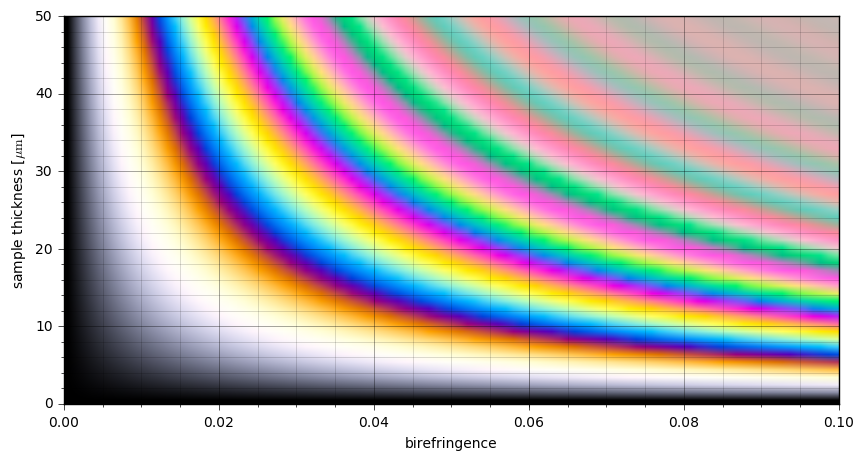

In [18]:
#--- plotting 

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

xlims = [min(birefringences), max(birefringences)]
ylims = [min(thicknesses), max(thicknesses)]
aspect = 10**-3

ax.imshow(np.flipud(plotimage), origin="upper", extent=xlims+ylims, aspect=aspect,zorder=1) 
ax.set_xlabel("birefringence")
ax.set_ylabel("sample thickness [$\mathrm{\mathrm{\mu m}}$]")

ax.minorticks_on()
ax.grid("on", which="major", ls="-", lw=0.5, alpha=0.5)
ax.grid("on", which="minor", ls="-", lw=0.5, alpha=0.2)
ax.tick_params(which="both", direction="out", right="off", top="off")

plt.savefig("./images/chart2.pdf")
plt.savefig("./images/chart2.png")
plt.show()

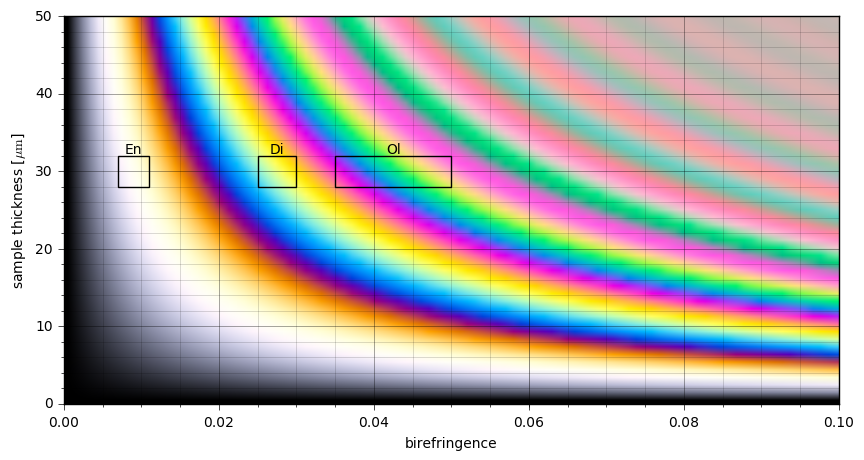

In [20]:
#--- same plot, but with added rectangles for minerals 
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

xlims = [min(birefringences), max(birefringences)]
ylims = [min(thicknesses), max(thicknesses)]
aspect = 10**-3

ax.imshow(np.flipud(plotimage), origin="upper", extent=xlims+ylims, aspect=aspect,zorder=1) 
ax.set_xlabel("birefringence")
ax.set_ylabel("sample thickness [$\mathrm{\mathrm{\mu m}}$]")

ax.minorticks_on()
ax.grid("on", which="major", ls="-", lw=0.5, alpha=0.5)
ax.grid("on", which="minor", ls="-", lw=0.5, alpha=0.2)
ax.tick_params(which="both", direction="out", right="off", top="off")

thickness = [28,32]
enstatite = [0.007,0.011]
diopsid = [0.03,0.025]
olivine = [0.035, 0.05]

loopdict = {"En": [thickness, enstatite], 
           "Di": [thickness, diopsid],
           "Ol": [thickness, olivine]}

for key, val in loopdict.items():
    text = key
    xspan = val[1]
    yspan = val[0]
    R = Rectangle((xspan[0], yspan[0] ),    # x,y of lower left corner
                   (xspan[1]-xspan[0]),          # width
                   (yspan[1]-yspan[0]),  # height
                   facecolor="none",
                  edgecolor="black",
                   zorder=100)
    ax.add_patch(R)
    ax.text(xspan[0]+0.5*(xspan[1]-xspan[0]), yspan[1], text,
            color="black",
            ha="center", va="bottom")
            
plt.savefig("./images/chart2_wboxes.pdf")
plt.savefig("./images/chart2_wboxes.png")
plt.show()

## Example: Color as a function of birefringence for a fixed thickness

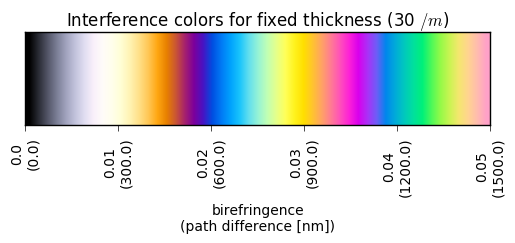

In [10]:
#--- calculation
RGB_one_thickness = []
birefs = np.arange(0, 0.05+0.001, 0.001)
thickness = 30E3
for biref in birefs:
    RGB_one_thickness.append(calculate_color(biref*thickness))
RGB_one_thickness = np.array(RGB_one_thickness)
    
plotimage = np.zeros([100,len(birefs),3])
plotimage[:,:,:] = RGB_one_thickness[:,:]

#--- plot
fig,ax = plt.subplots(1)

xlims = [min(birefs), max(birefs)]
ylims = [0,100]

aspect = 1E-4
ax.imshow(plotimage, origin="upper", extent=xlims+ylims, aspect=aspect)
         
ax.set_yticks([])

xticks = np.arange(xlims[0], xlims[1]+0.01, 0.01)
xticks_gamma = xticks*thickness
xticklabels = ["{:}\n({:})".format(a,b) for a,b in zip(xticks,xticks_gamma)]
ax.set_xticklabels(xticklabels, rotation=90)

ax.set_title("Interference colors for fixed thickness ({:.0f} $\mu m$)".format(thickness*1E-3))
ax.set_xlabel("birefringence\n(path difference [nm])")
ax.tick_params(direction="out", top="off")

plt.savefig("./images/fixed_thickness.pdf")
plt.savefig("./images/fixed_thickness.png")
plt.show()

## Example: Color as a function of thickness for a fixed birefringence

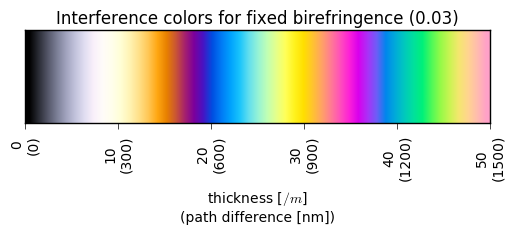

In [11]:
#--- calculation
biref = 0.03
thicknesses = np.arange(0,51,1)

RGB_one_biref = []
for thickness in thicknesses:
    RGB_one_biref.append(calculate_color(biref*thickness*1000))
RGB_one_biref = np.array(RGB_one_biref)
    
plotimage = np.zeros([100,len(thicknesses),3])
plotimage[:,:,:] = RGB_one_biref[:,:]

#--- plot
fig,ax = plt.subplots(1)

xlims = [min(thicknesses), max(thicknesses)]
ylims = [0,100]

aspect = 1E-1
ax.imshow(plotimage, origin="upper", extent=xlims+ylims, aspect=aspect)

ax.set_yticks([])

xticks = np.arange(xlims[0], xlims[1]+10, 10)
xticks_gamma = xticks*biref*1000
xticklabels = ["{:g}\n({:g})".format(a,b) for a,b in zip(xticks,xticks_gamma)]
ax.set_xticklabels(xticklabels, rotation=90)

ax.set_title("Interference colors for fixed birefringence ({:g})".format(biref))
ax.set_xlabel("thickness [$\mu m$]\n(path difference [nm])")

ax.tick_params(direction="out", top="off")

plt.savefig("./images/fixed_birefringence.pdf")
plt.savefig("./images/fixed_birefringence.png")
plt.show()

## Example: Widget to calculate color for birefringence and thickness

Choose birefringence and thickness. Simulates color shift when using a compensator by changing the path difference Gamma.

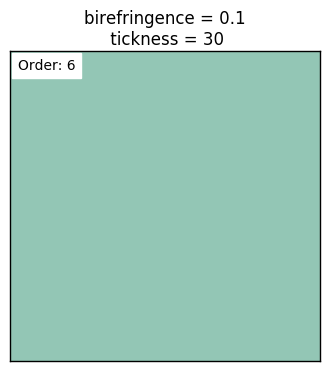

<function __main__.plot_color>

In [12]:
from ipywidgets import interactive, interact

def plot_color(birefringence, thickness, compensator=0):
    #--- Calculate path difference and optional and shift
    Gamma = birefringence * thickness*1E3
    Gamma += 550*compensator
    #--- determine color order
    order = 0
    check = 0
    while True:
        if Gamma < check:
            break
        check += 550
        order += 1
        
    #--- get color
    color = calculate_color(Gamma)

    #--- plot
    plotimage = np.zeros([20,20,3])
    plotimage[:,:,:] = color
    plt.close("all")
    fig,ax = plt.subplots(1)
    ax.imshow(plotimage, origin="upper")
    ax.set_xticks([])
    ax.set_yticks([])
    text = "birefringence = {:}\n tickness = {:}".format(birefringence, thickness)
    ax.set_title(text)
    
    ax.text(0,0,"Order: {:d}".format(order), backgroundcolor="white",
           ha="left", va="top")
    plt.show()


#--- NOTE: you can change the ranges and steps of the sliders [start, stop, step]
interact(plot_color, 
         birefringence=[0,0.2,0.0001],
         thickness=[20,40,2], 
         compensator=[-2,2,1])